# TP: Introduction to k-Nearest Neighbors (k-NN)

In this TP, you will implement a simple k-Nearest Neighbors (k-NN) classifier in Python.

### Overview of k-NN:
The k-NN algorithm is a straightforward and widely used classification technique. It operates in two stages:

1. **Training Stage**:  
   The classifier simply stores or "remembers" the entire training dataset. There is no actual "training" in the conventional sense, as k-NN is a lazy learning algorithm—it defers the computation until the testing stage.

2. **Testing Stage**:  
   During testing, the classifier assigns a label to each test sample by:
   - Comparing the test sample to all the training samples.
   - Identifying the $k$ nearest neighbors based on a chosen distance metric (e.g., Euclidean distance).
   - Assigning the label that is most frequent among the $k$ nearest neighbors.

### Step-by-Step Guide:
1. **Mathematical Foundations**:  
   You will first derive the following mathematical operations by hand:
   - The **difference** between two vectors.
   - The **inner product** of two vectors.
   - The **norm** of a vector.
   
   After deriving these, you will implement these operations in Python and verify that the computed results match your manual calculations.

2. **Implementing k-NN**:  
   Using the operations you’ve implemented (difference, inner product, and norm), you will write the prediction step for the k-NN algorithm. This step will compute distances between test samples and training samples to find the nearest neighbors and assign labels accordingly.

### Instructions:
- You will only need to modify two files for this practical:
  1. **This notebook**: Where you will run the tests and evaluate your implementation.
  2. **k_nearest_neighbor.py**: Where you will implement the k-NN classifier and the necessary vector operations.
  
- **Important**: All other files can be ignored and do not require any changes.


In [105]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

from data_utils import load_IRIS, load_CIFAR10
from visualizer import Visualizer
from k_nearest_neighbor import KNearestNeighbors

# make figures appear inline
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Iris dataset: model complexity and decision surfaces

To do our experiments we will use a dataset named [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). This dataset has 150 samples from 3 classes, 50 from each one (Iris setosa, Iris virginica and Iris versicolor) and each sample has 4 attributes (Sepal Length, Sepal Width, Petal Length and Petal Width).

We will start by loading our dataset and by instantiating the visualization tool that will allow us to visualize the vectors.


Clear previously loaded data.
Training data shape:  (100, 2)
Training labels shape:  (100,)
Test data shape:  (50, 2)
Test labels shape:  (50,)


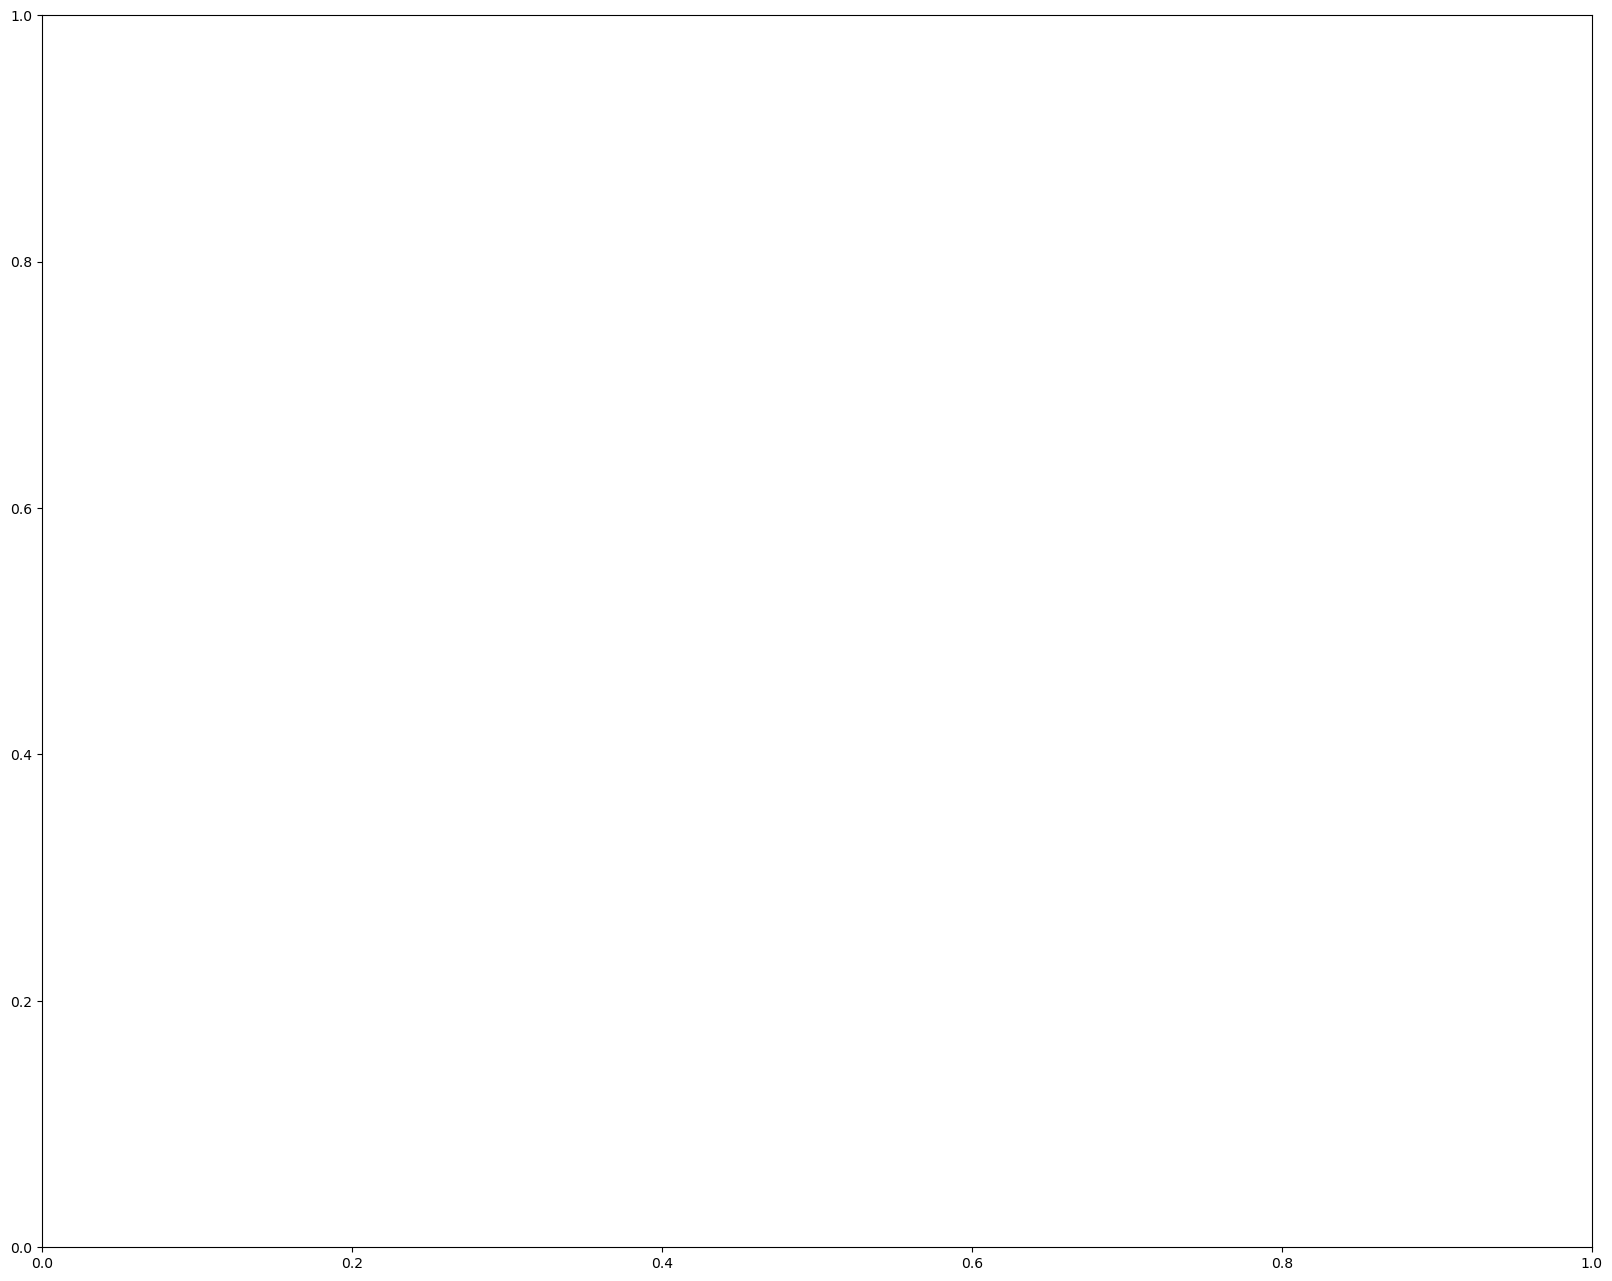

In [106]:
# Load the Iris data.
# Cleaning up variables
try:
    del X_train, y_train
    del X_test, y_test
    print("Clear previously loaded data.")
except:
    pass


# Function to load the data
def get_data(n_features=None, offset=0, verbose=False):
    axes_labels = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]
    attribut_1 = 0
    attribut_2 = 2

    X_train, y_train, X_test, y_test = load_IRIS(test=True)
    features_names = axes_labels
    if n_features is not None:
        if n_features <= X_train.shape[1]:
            X_train_tmp, X_test_tmp, features_names = [], [], []
            for i in range(n_features):
                X_train_tmp.append(X_train[:, i + offset])
                X_test_tmp.append(X_test[:, i + offset])
                features_names.append(axes_labels[i + offset])
            X_train = np.array(X_train_tmp).T
            X_test = np.array(X_test_tmp).T

    if verbose:
        # As a sanity check, we print out the size of the training and test data.
        # we use all the data as training
        print("Training data shape: ", X_train.shape)
        print("Training labels shape: ", y_train.shape)
        print("Test data shape: ", X_test.shape)
        print("Test labels shape: ", y_test.shape)
    return X_train, y_train, X_test, y_test, features_names


X_train, y_train, X_test, y_test, features_names = get_data(
    n_features=2, offset=1, verbose=True
)

# load the visualisation tool
vis = Visualizer()

To help you implement the next functions we will take a query point from the test set and a point from the training set.

You should use this to derive by hand the formulas and do the calculus.


In [107]:
# lets take a sample from the test set to use as query
# we will focus on second and last features ('Sepal Width' and 'Petal Width')
idx = y_test.tolist().index(2)
query = X_test[idx]
query_y = y_test[idx]

# now we take a sample from the training set
point = X_train[0]
point_y = y_train[0]

# visualization
vis.add_vector(query, label="q")
vis.add_vector(point, label="p")
vis.show()

# print vectors
print(f"Point = {point.tolist()}")
print(f"Query = {query}\n")

Point = [3.5, 1.3]
Query = [3.  5.2]



**Question**

Write on your report how to compute the difference between two vectors theoretically.

Lets take the sum of two vectors as example: $$p + q = (p_1, p_2) + (q_1, q_2) = (p_1 + q_1, p_2 + q_2 ) $$

and then write the calculus using the p and q from previous cell:
$$p + q = (3.5, 1.3) + (3., 5.2) = (3.5 + 3, 1.3 + 5.2 ) = (6.5, 6.5) $$

Finally, you should implement this and compare the result with what you obtained:

```python
>>> def addition(A, B):
...     return A + B
...
>>> addition(point, query)
array([6.5, 6.5])
```

If the result of the function matches what you obtained by hand, it should be correct =).

_Answer this question in your report_


Point = [3.5, 1.3]
Query = [3.  5.2]

Difference = P - Q = [ 0.5 -3.9]


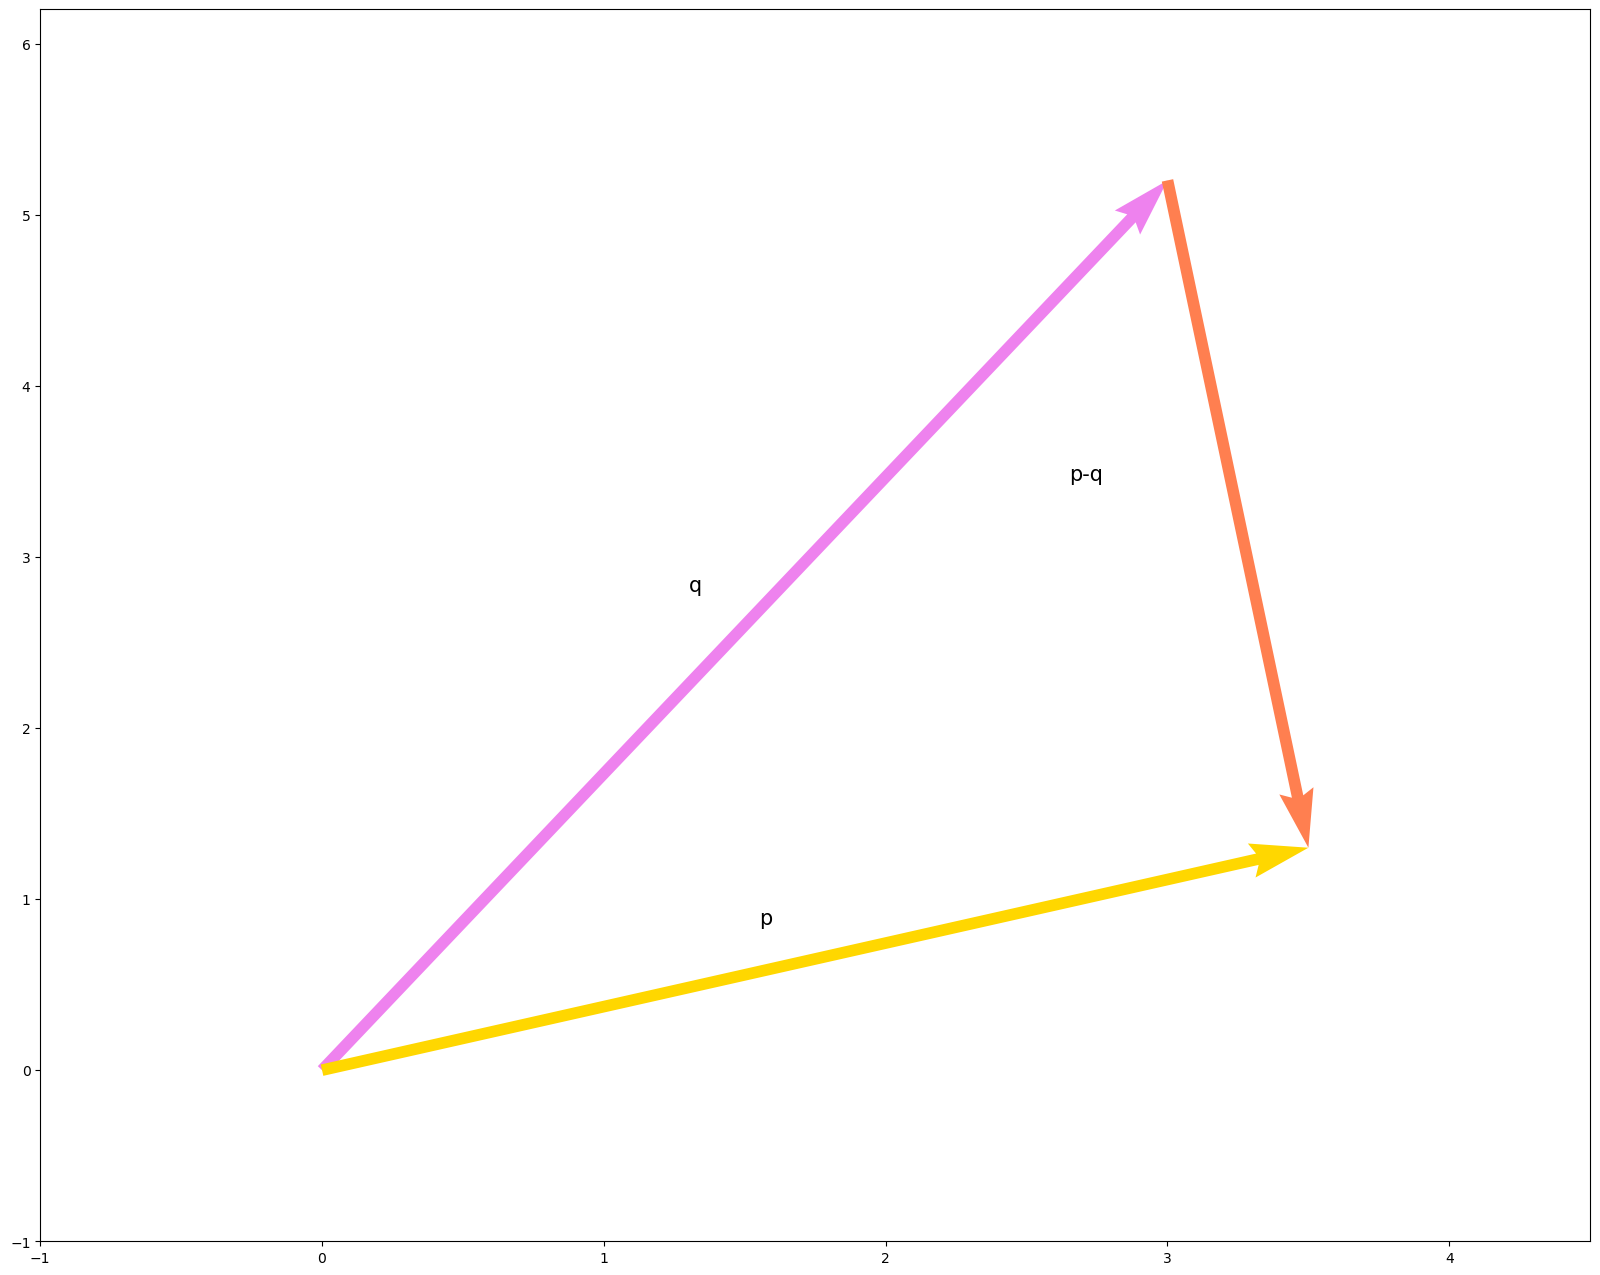

In [108]:
from k_nearest_neighbor import difference

# define difference in k_nearest_neighbor.difference and visualize it here (use same visualizer as above)

vis.clear()
vis.add_vector(query, label="q")
vis.add_vector(point, label="p")

# implement this function in k_nearest_neighbor.py
diff = difference(point, query)

vis.add_vector(diff, origin=query, label="p-q")

print(f"Point = {point.tolist()}")
print(f"Query = {query}\n")
print(f"Difference = P - Q = {diff}")

What if we do point - query instead?


Point = [3.5, 1.3]
Query = [3.  5.2]

Difference = Q - P = [-0.5  3.9]


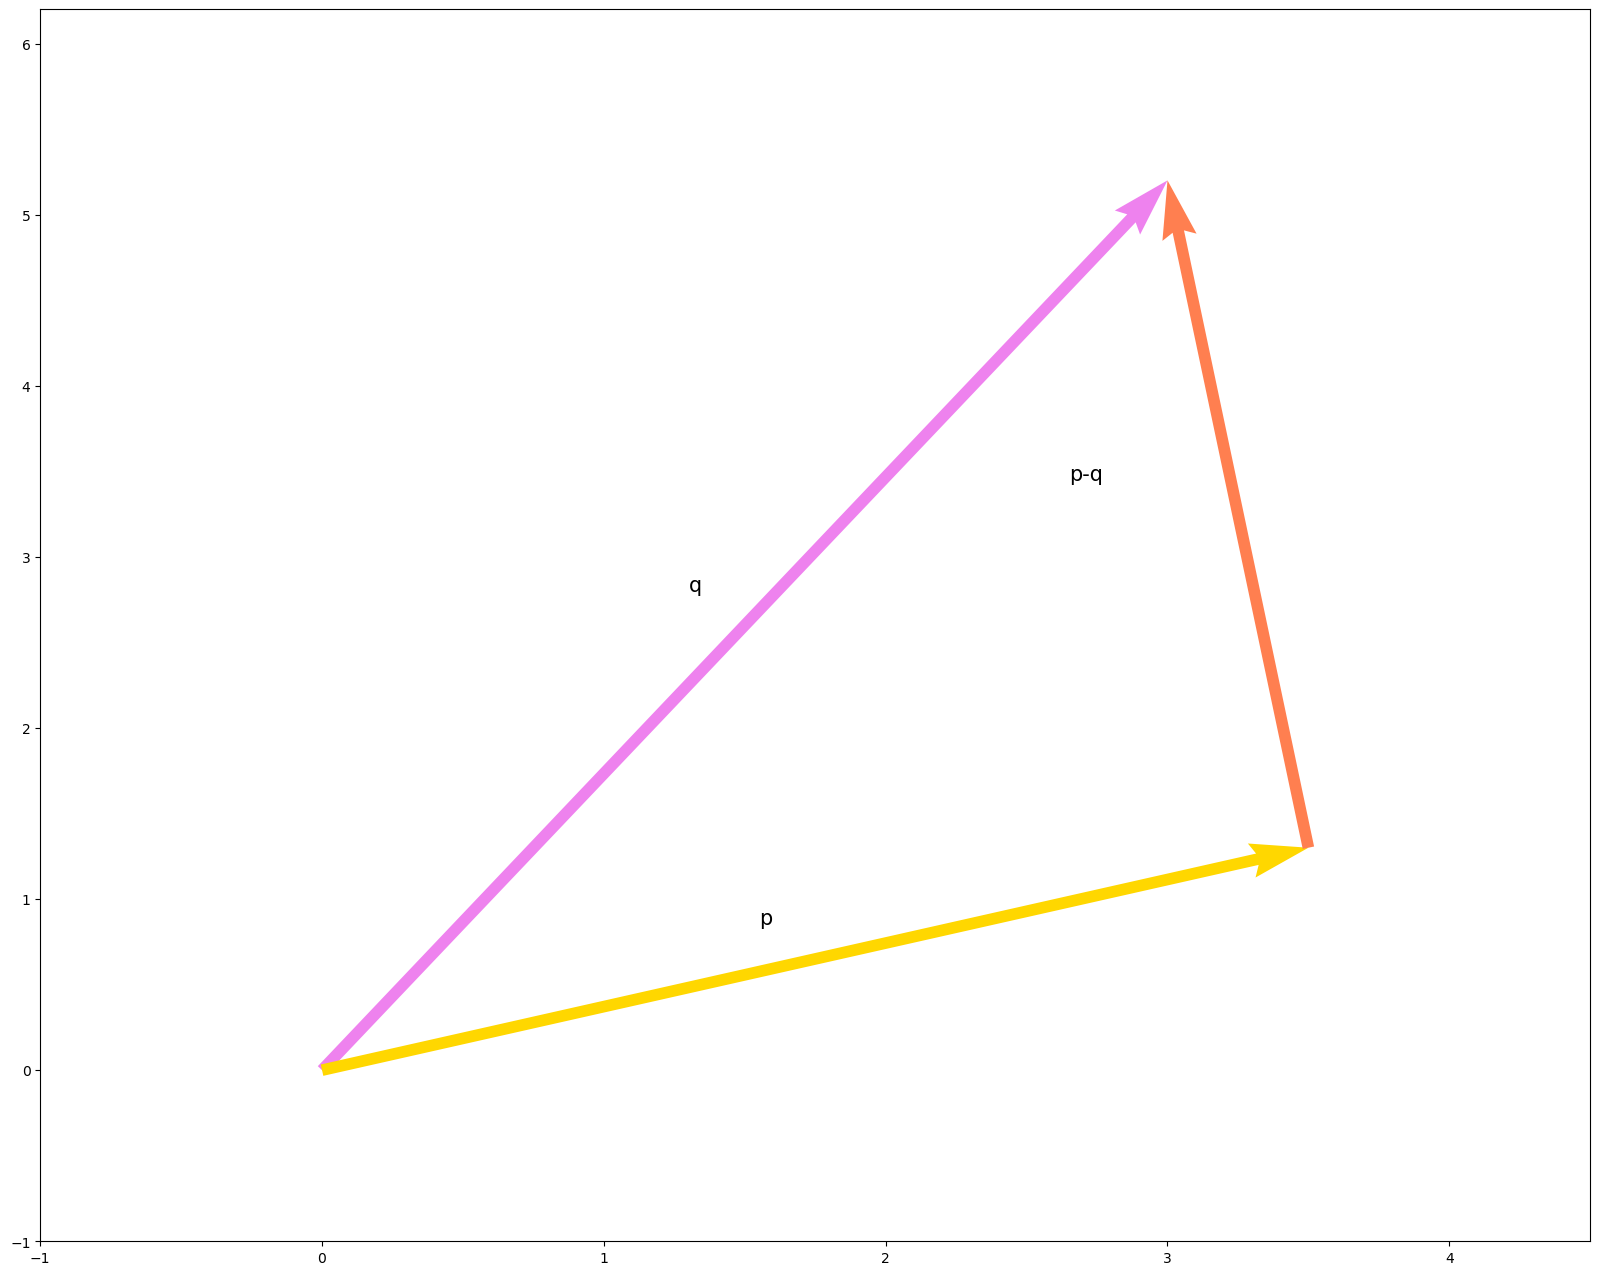

In [109]:
vis.clear()
vis.add_vector(query, label="q")
vis.add_vector(point, label="p")

diff = difference(query, point)
vis.add_vector(diff, origin=point, label="p-q")

print(f"Point = {point.tolist()}")
print(f"Query = {query}\n")
print(f"Difference = Q - P = {diff}")

**Question**

Is there a difference between (point - query) or (query - point) ? If there is any, comment on the differences.
What should be chosen for knn ?

_Answer this question in your report_


**Question**

Do the same with the inner product between point and query.

1. Give the formula
2. Derive the formula
3. Replace with the value of the point and query vector
4. Solve the calculus
5. Implement k_nearest_neighbor.inner_product (in k_nearest_neighbor.py)
6. Verify that the result is the same as the one you got in 4

_Answer this question in your report_


In [110]:
from k_nearest_neighbor import inner_product

# write the inner product of the difference between the point and query in k_nearest_neighbor.py and verify that the result is the same as the one you got on paper.

print(f"Point = {point.tolist()}")
print(f"Query = {query}\n")

inner_product = inner_product(point, query)

print(f"Inner product = {inner_product:.2f}")

Point = [3.5, 1.3]
Query = [3.  5.2]

Inner product = 17.26


**Question**

Do the same with the norm between the difference of point and query.

1. Give the formula
2. Derive the formula
3. Replace with the value of the point and query vector
4. Solve the calculus
5. Implement k_nearest_neighbor.norm (in k_nearest_neighbor.py)
6. Verify that the result is the same as the one you got in 4

_Answer this question in your report_


In [111]:
from k_nearest_neighbor import difference, norm

difference_pq = difference(point, query)

print(f"Point = {point.tolist()}")
print(f"Query = {query}")
print(f"Difference(P, Q) = point - query = {difference_pq}\n")

norm_pq = norm(difference_pq, difference_pq)

print(f"Norm(P-Q) = {norm_pq:.2f}")

Point = [3.5, 1.3]
Query = [3.  5.2]
Difference(P, Q) = point - query = [ 0.5 -3.9]

Norm(P-Q) = 3.93


Repeat the exercice with the difference between query and point this time and answer the following question (see below).


In [112]:
from k_nearest_neighbor import difference, norm

difference_qp = difference(query, point)

print(f"Point = {point.tolist()}")
print(f"Query = {query}")
print(f"Difference(Q, P) = query - point = {difference_qp}\n")

norm_qp = norm(difference_qp, difference_qp)

print(f"Norm(Q-P) = {norm_qp:.2f}")

Point = [3.5, 1.3]
Query = [3.  5.2]
Difference(Q, P) = query - point = [-0.5  3.9]

Norm(Q-P) = 3.93


**Question**

1. Explain to what does the norm correspond in the plots you had before (p-q)? Explain.
2. Is there a difference between the norm of the difference between Q and P, and P and Q? Explain the differences (or the lack of difference).
3. Why do we need the norm for knn ?

_Answer this question in your report_


Now it is time to implement the predict_label method of the knn.
This method takes a query and a number of neighbors and get the k closest neighbors of the query. Then it returns the label of the majority.

Implement this method on k_nearest_neighbor and verify that the next cell runs and return a predicted label equal to 0.


In [113]:
from k_nearest_neighbor import KNearestNeighbors

# knn does not need to do any training, here it will mainly store the data to be used later by the prediction methods.

X_train, y_train, X_test, y_test, features_names = get_data(n_features=2)

knn = KNearestNeighbors()

knn.train(X_train, y_train)

label = knn.predict_label(query, k=3)

print(
    f"The predicted label is {label}, the true label is {query_y} (may be different)."
)

The predicted label is 0.0, the true label is 2 (may be different).


Now we need to extend the previous method to work with a complete test set. This should be simple to implement, since it is mainly a loop over the previous method.

Implement the predict method on k_nearest_neighbor.py and the accuracy function on the cell bellow. The accuracy function should return the accuracy between the predicted and the true labels in percentage!


In [117]:
def accuracy(labels, predictions):
    acc = 0
    ## insert your code here ##
    ... 
    #### end of your code ####
    return acc


labels_predicted = knn.predict(X_test)

acc = accuracy(y_test, labels_predicted)

# should give an accuracy of 60%
print(f"Accuracy: {acc:.2f}/100 %")

Accuracy: 0.00/100 %


Until now, we have used only two features. However, the dataset contains four features per sample. Bellow, we will explore what happens when we increase the number of features.

#### Number of features = 3


In [118]:
X_train, y_train, X_test, y_test, features_names = get_data(n_features=3, verbose=True)

Training data shape:  (100, 3)
Training labels shape:  (100,)
Test data shape:  (50, 3)
Test labels shape:  (50,)


In [119]:
knn = KNearestNeighbors()
knn.train(X_train, y_train)

labels_predicted = knn.predict(X_test)

acc = accuracy(y_test, labels_predicted)

print(f"Accuracy: {acc:.2f} %")

Accuracy: 0.00 %


#### Number of features = 4


In [30]:
X_train, y_train, X_test, y_test, features_names = get_data(verbose=True)

Training data shape:  (100, 4)
Training labels shape:  (100,)
Test data shape:  (50, 4)
Test labels shape:  (50,)


In [31]:
knn = KNearestNeighbors()
knn.train(X_train, y_train)

labels_predicted = knn.predict(X_test)

acc = accuracy(y_test, labels_predicted)

print(f"Accuracy: {acc:.2f} %")

Accuracy: 0.00 %


_Comment this results on your report ! How does the number of features change the performance of the knn ? What would you expect ? If the results you obtained differ from the your expected results, comment on the possible reasons._


## Decision surface
Visualize, study, and discuss the decision surfaces that kNN algorithm produces for the different values of k.


* To do so, you will work only in two attributes.

     * Testing will be done on an artificially generated dataset that covers in a regular manner all possible values for the two chosen attributes. To do so we need to divide the space into a grid by discretizing the space  into $n$ values between the minimum and maximum value of an attribute. Each of these values must be compared with the $n$ discrete values of the second attribute. The resulting array will be of shape ($n$ * $n$, 2)
     
     * Using your training set classify your test instances and visualize the results of the classification
     
See how the performance changes with respect to the value of k. Explain how the different values of the k change the classification boundaries in the instance space for a given training set. 



In [32]:
# Load the Iris data.
# Cleaning up variables to prevent loading data multiple times (which may cause memory issues)
try:
    del X_train, y_train
    del X_test, y_test
    print("Clear previously loaded data.")
except:
    pass

X_train, y_train = load_IRIS(test=False)

axes_labels = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

# For our visualisation we will only keep the two first attributs.
# You can choose 2 attribus here
attribut_1 = 1
attribut_2 = 3

X_train_2_features = np.array([X_train[:, attribut_1], X_train[:, attribut_2]]).T
axes_label_1 = axes_labels[attribut_1]
axes_label_2 = axes_labels[attribut_2]

# and the test set will be the matrix (n*n, 2) where n is the number of values taken between
# the min and the max of each attribute
n = 150

X_test = np.zeros((n * n, 2))
tmp = np.linspace(
    np.min(X_train_2_features[:, 0]) - 0.1, np.max(X_train_2_features[:, 0]) + 0.1, n
)
X_test[:, 0] = np.repeat(tmp, n)

tmp = np.linspace(
    np.min(X_train_2_features[:, 1]) - 0.1, np.max(X_train_2_features[:, 1]) + 0.1, n
)
X_test[:, 1] = np.tile(tmp, n)


print("Training data shape: ", X_train_2_features.shape)
print("Testing data shape: ", X_test.shape)

Clear previously loaded data.
Training data shape:  (150, 2)
Testing data shape:  (22500, 2)


Now we need to train our knn model using our training set (X_train_2_features and y_train)

In [33]:
knn = KNearestNeighbors()
knn.train(X_train_2_features, y_train)

Now we can used the trained model to predict the labels for the test set (X_test) using different values of k (or number of neighbors).

Predicting for K =  1
Predicting for K =  3
Predicting for K =  5
Predicting for K =  15


<Figure size 2000x1600 with 0 Axes>

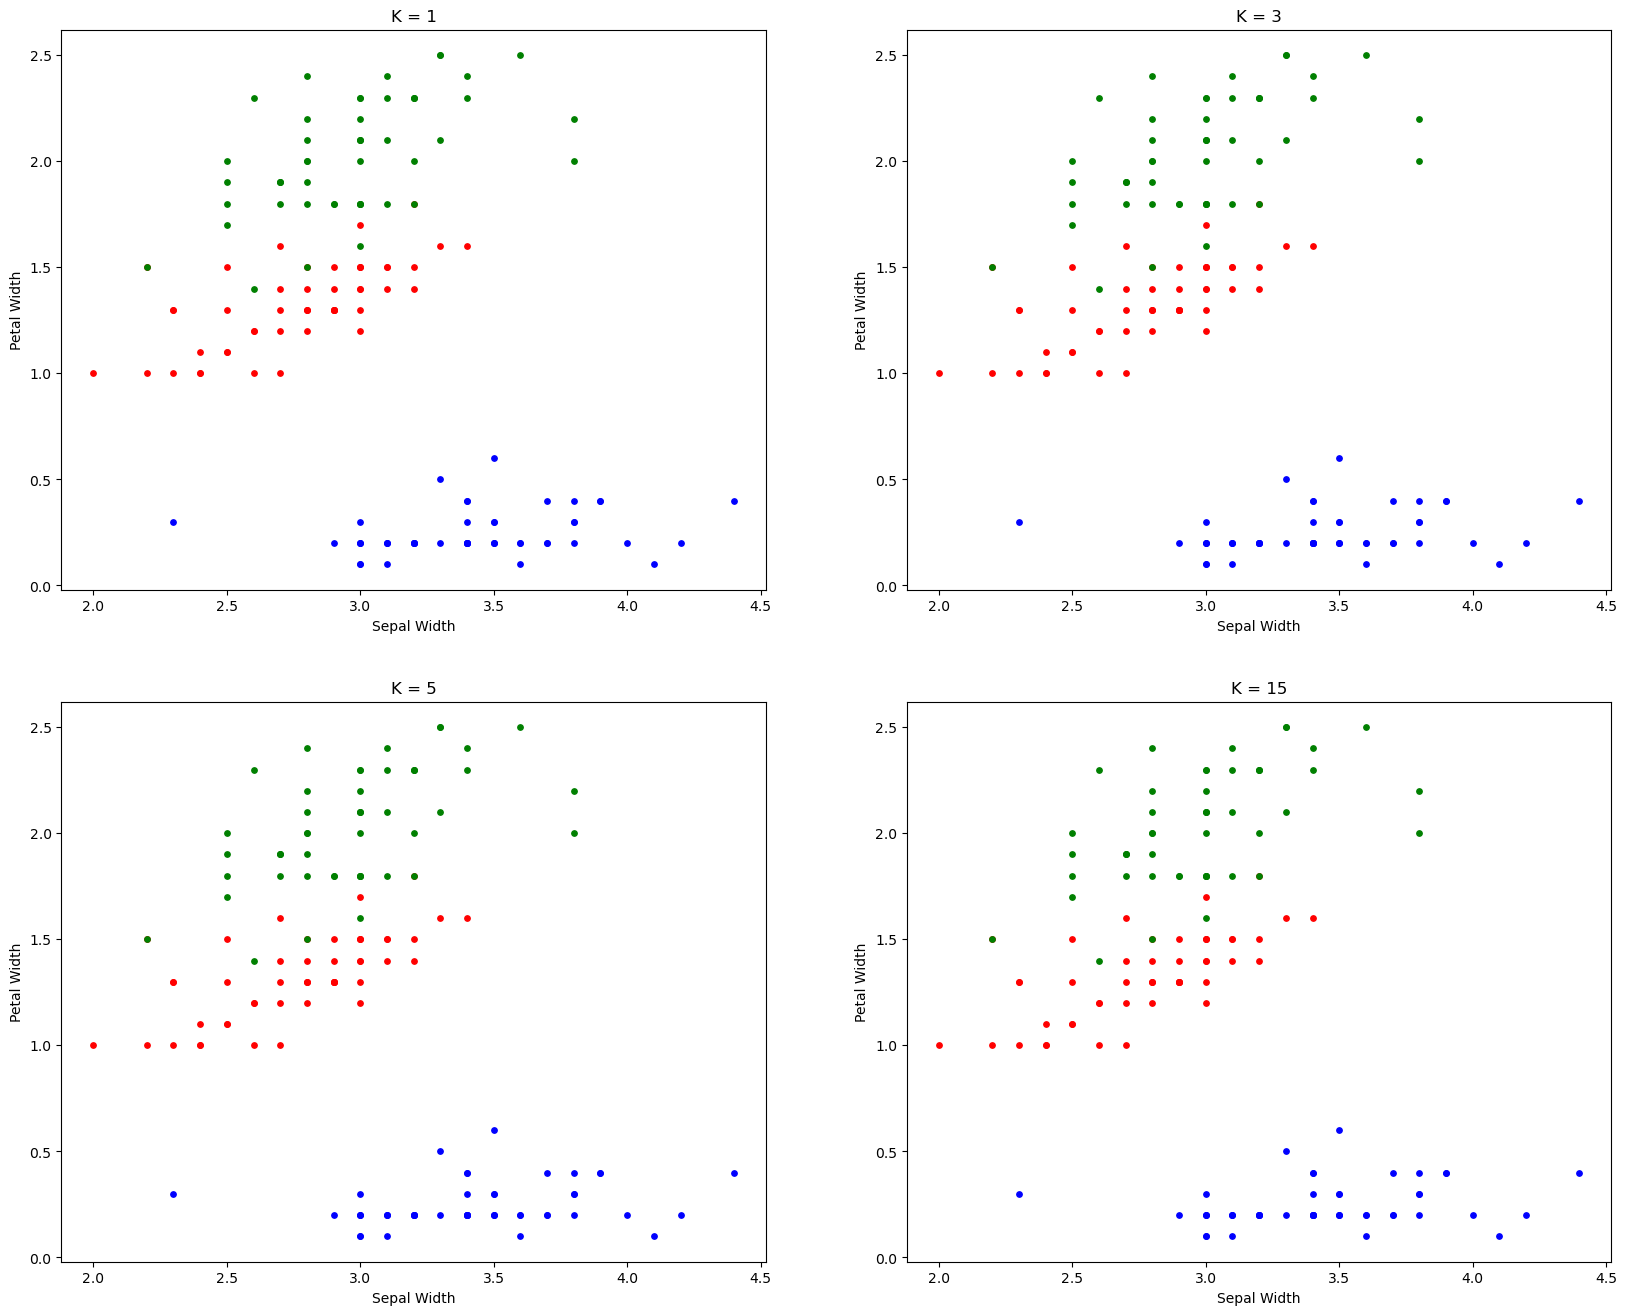

In [34]:
# plot the decision surface
colors_surfaces = ["#88E2EA", "#FFE1BB", "#D4F3CD"]
colors_points = ["blue", "red", "green"]

plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.clf()
fig = plt.figure()

# test
k_values = [1, 3, 5, 15]
i = 0
for n_of_neighbors in k_values:
    print("Predicting for K = ", n_of_neighbors)
    y_predicted = knn.predict(X_test, k=n_of_neighbors)
    y_predicted = np.array(y_predicted)

    ax = fig.add_subplot(2, 2, 1 + i)
    ax.set_title("K = " + str(n_of_neighbors))

    for n_class in range(3):
        x_train_attri_1 = X_train_2_features[y_train == n_class, 0]
        x_train_attri_2 = X_train_2_features[y_train == n_class, 1]

        x_test_attri_1 = X_test[y_predicted == n_class, 0]
        x_test_attri_2 = X_test[y_predicted == n_class, 1]

        ax.scatter(
            x_test_attri_1,
            x_test_attri_2,
            s=15,
            color=colors_surfaces[n_class],
            zorder=1,
        )
        ax.scatter(
            x_train_attri_1,
            x_train_attri_2,
            s=15,
            color=colors_points[n_class],
            zorder=2,
        )
        ax.set_xlabel(axes_label_1)
        ax.set_ylabel(axes_label_2)

    i += 1


# each color represent a class of the problem

# don't take care of the warning

**Question**  
See how the performance change with respect to the value of k. 
Explain how the different values of the k change the classification boundaries in the instance space for a given training set. 